In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model_seed_vector import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [4]:
cache_states = [n*10 for n in range(10)]

# Run Task

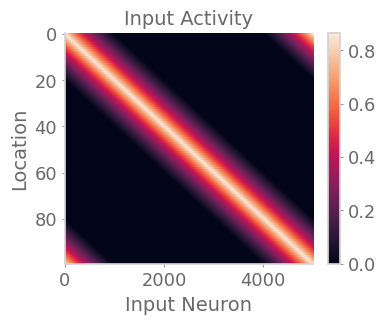

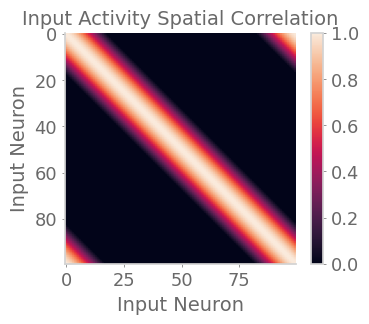

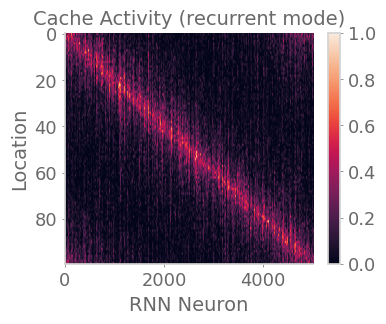

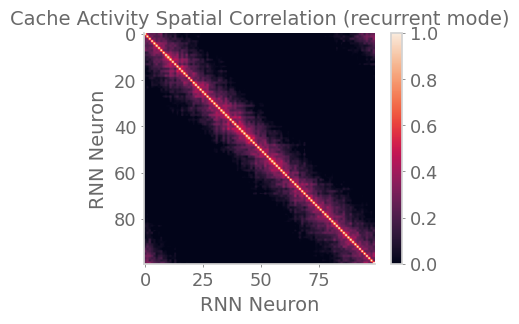

Sparsity: 0.123764


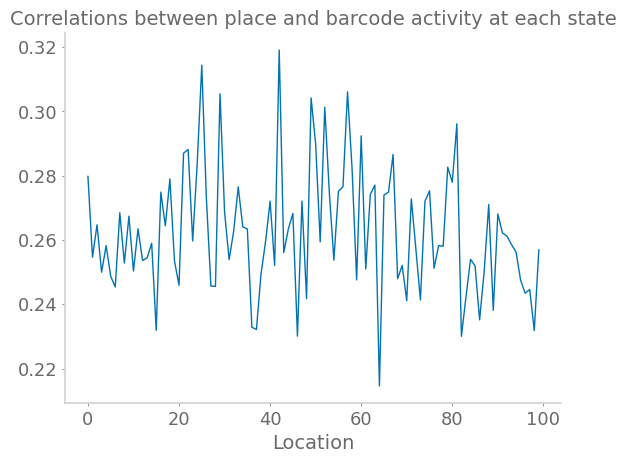

Now I just cached at location: 0


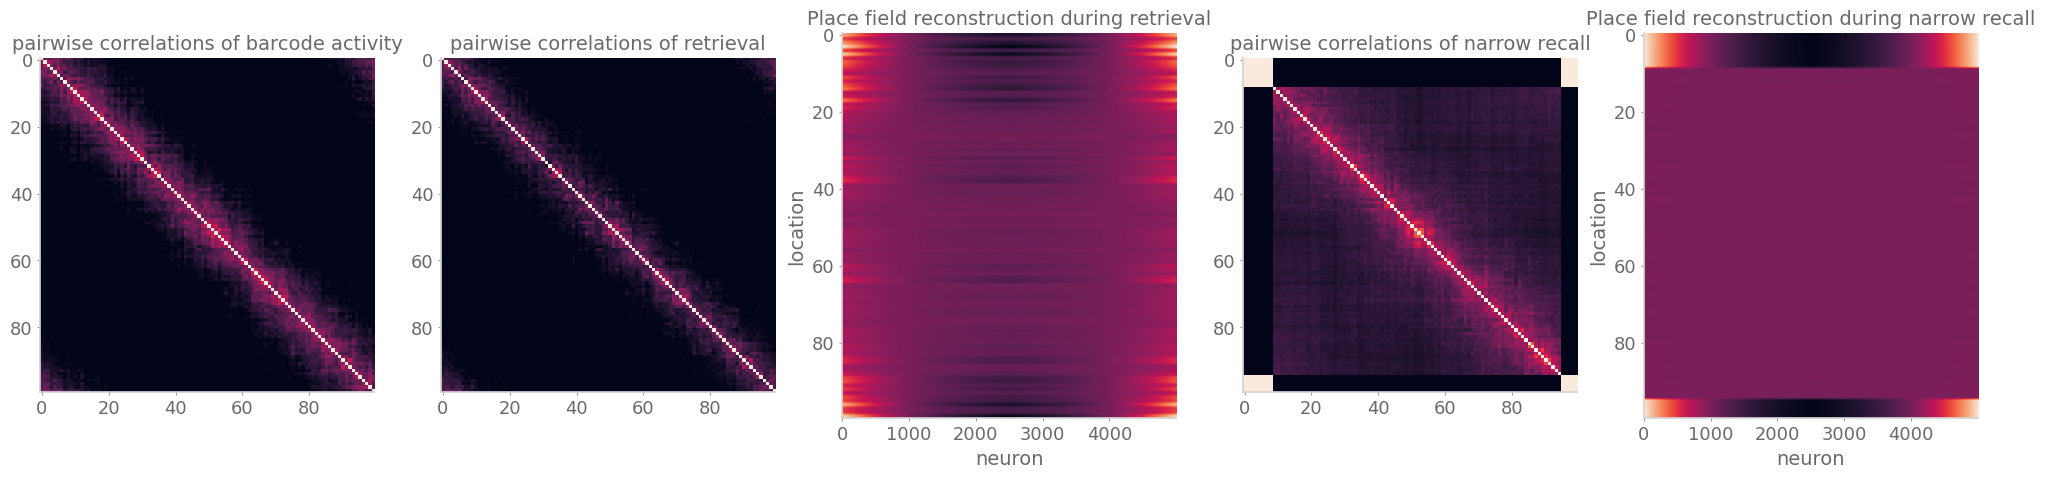

Now I just cached at location: 10


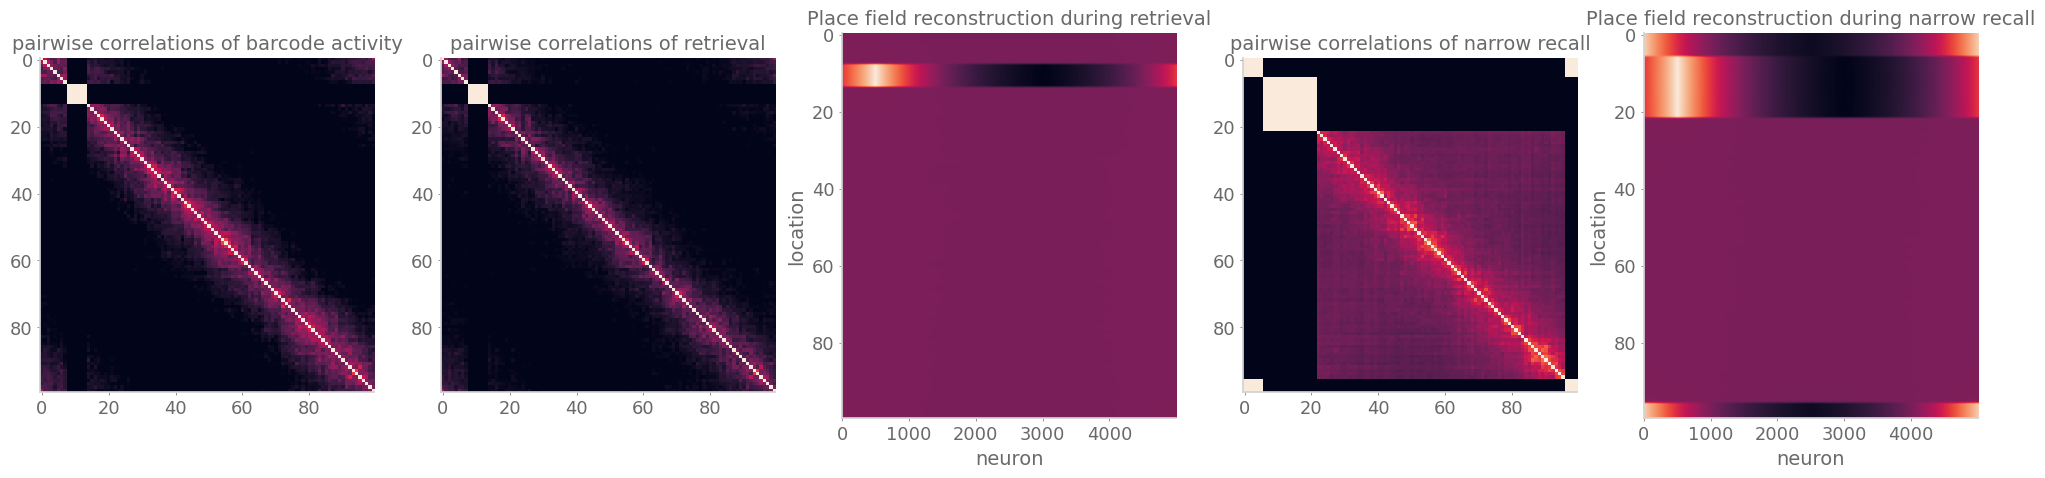

Now I just cached at location: 20


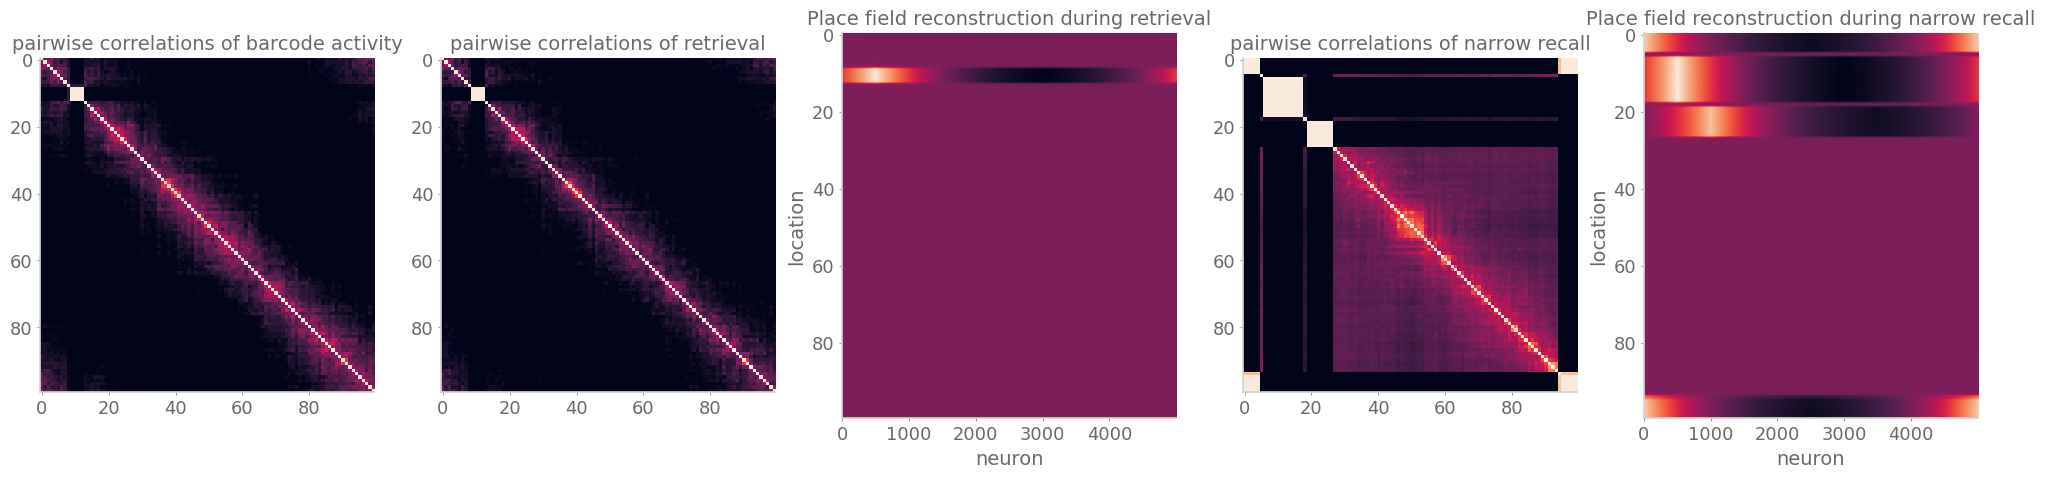

Now I just cached at location: 30


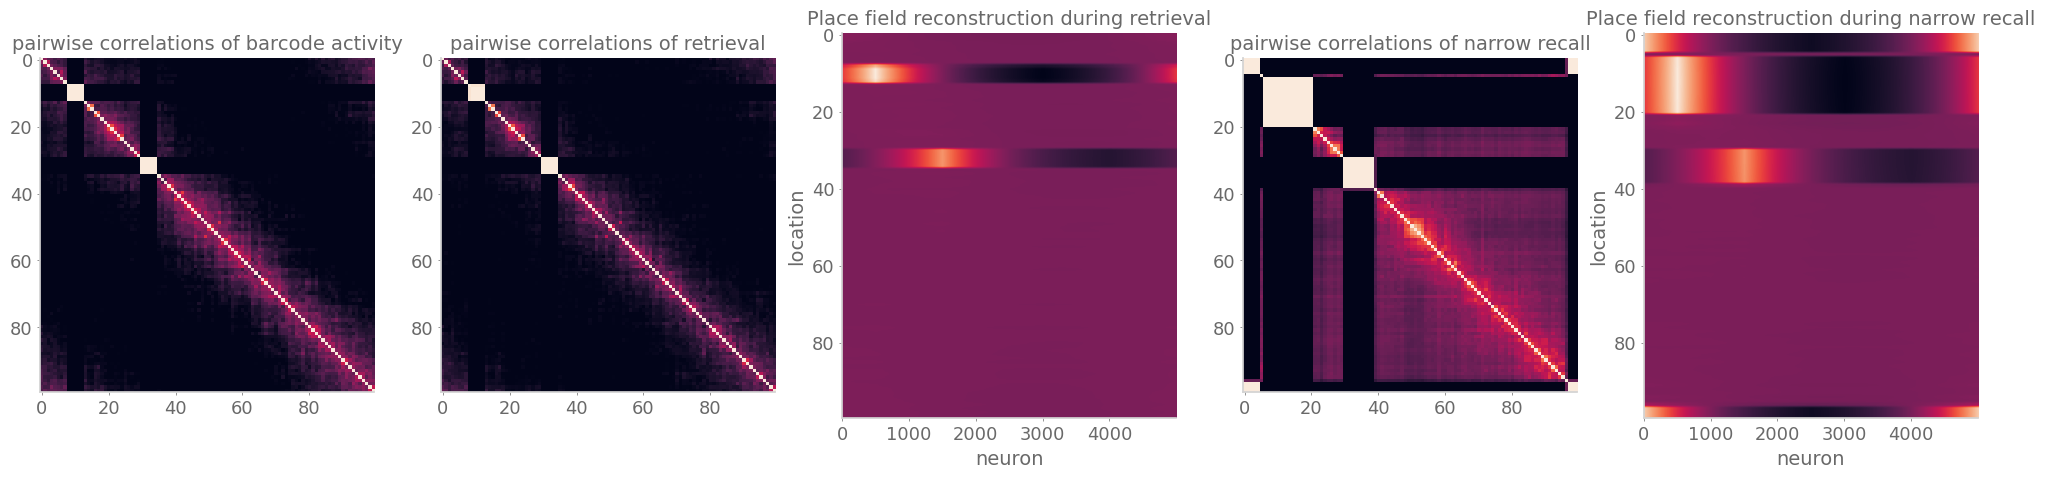

Now I just cached at location: 40


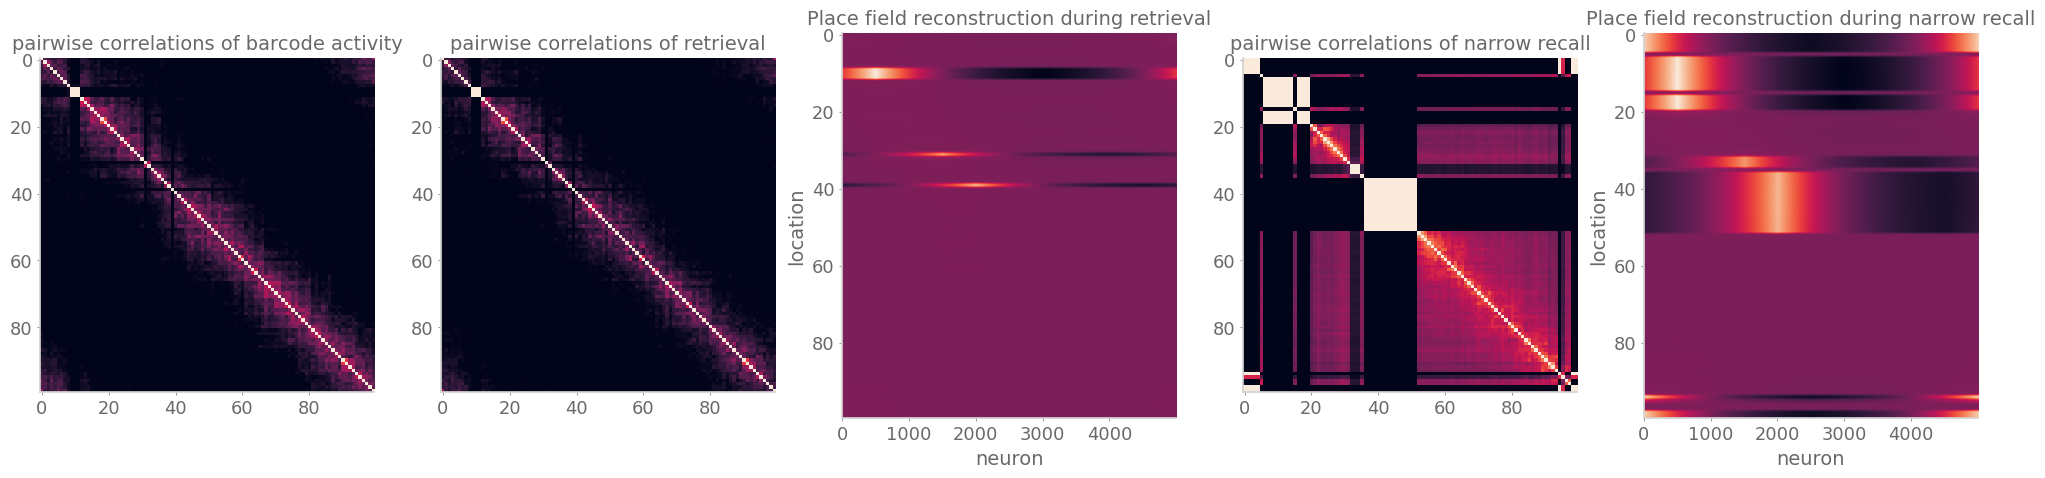

Now I just cached at location: 50


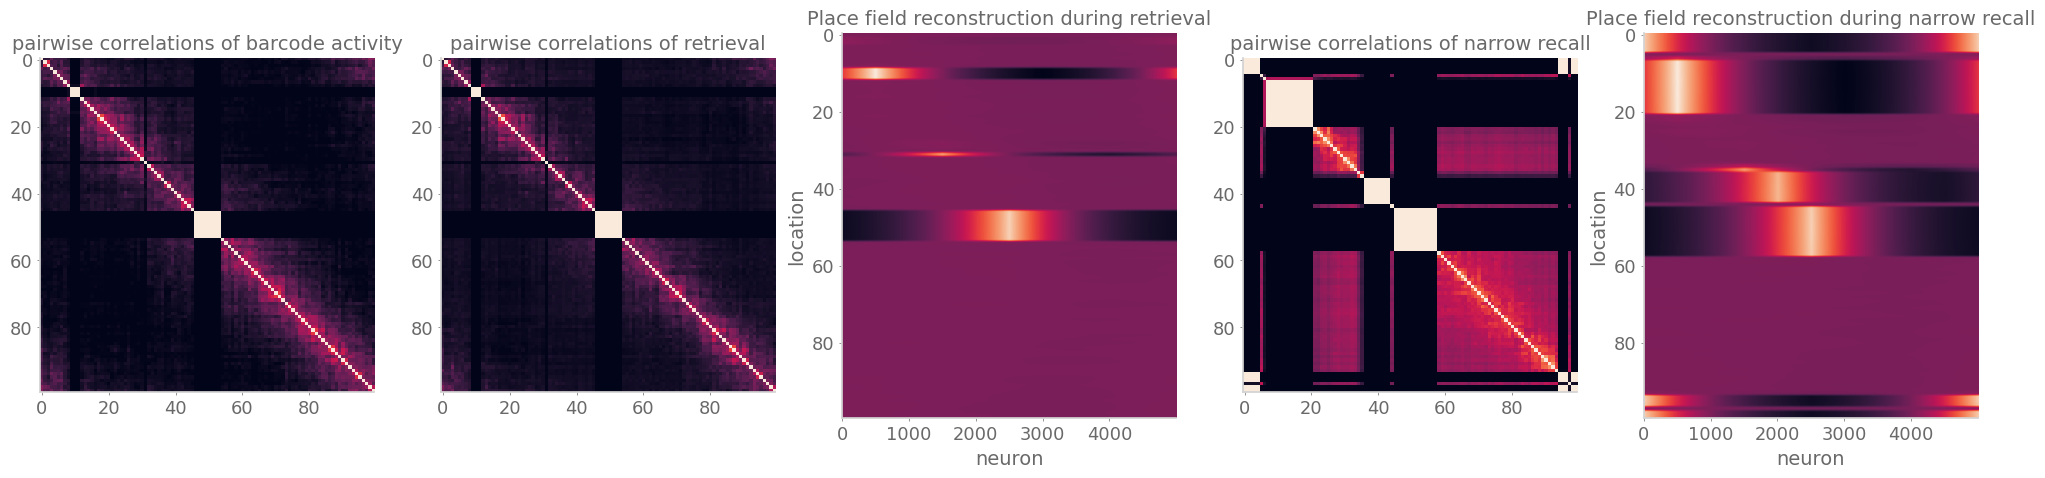

Now I just cached at location: 60


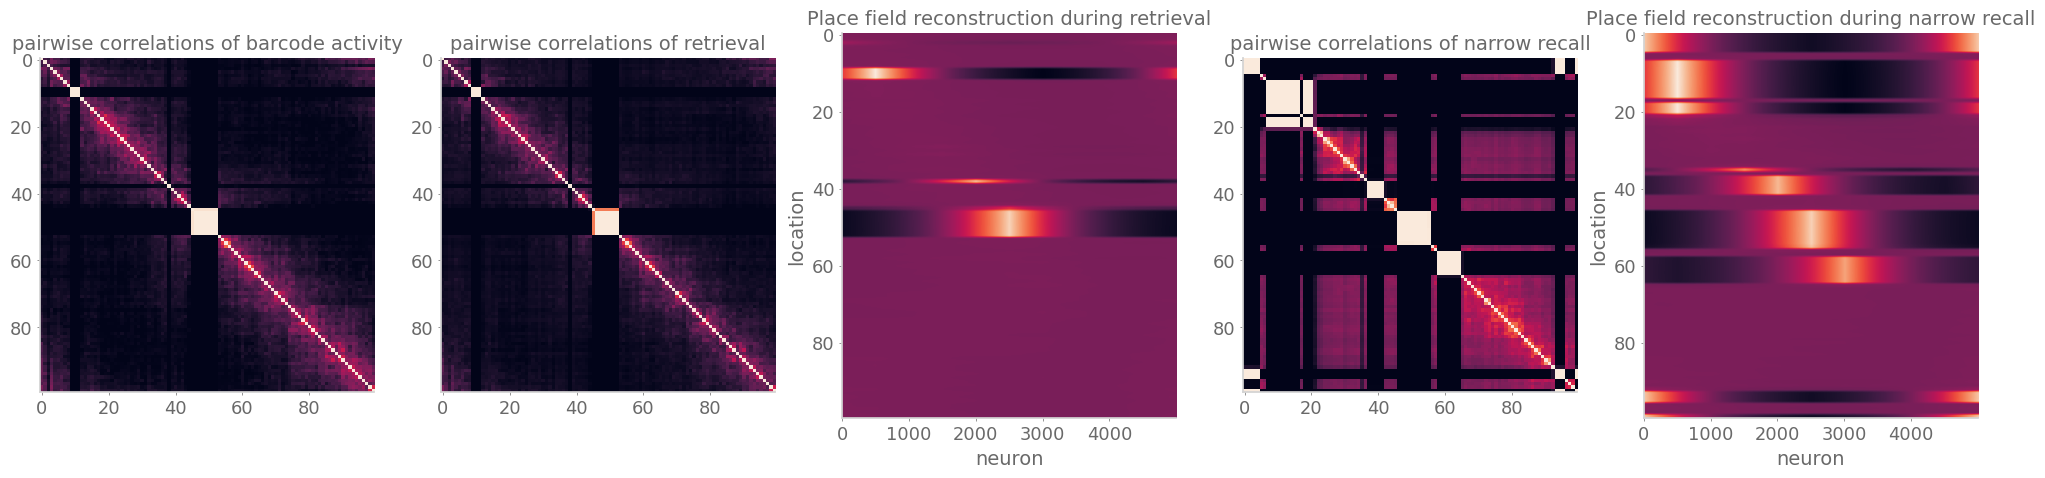

Now I just cached at location: 70


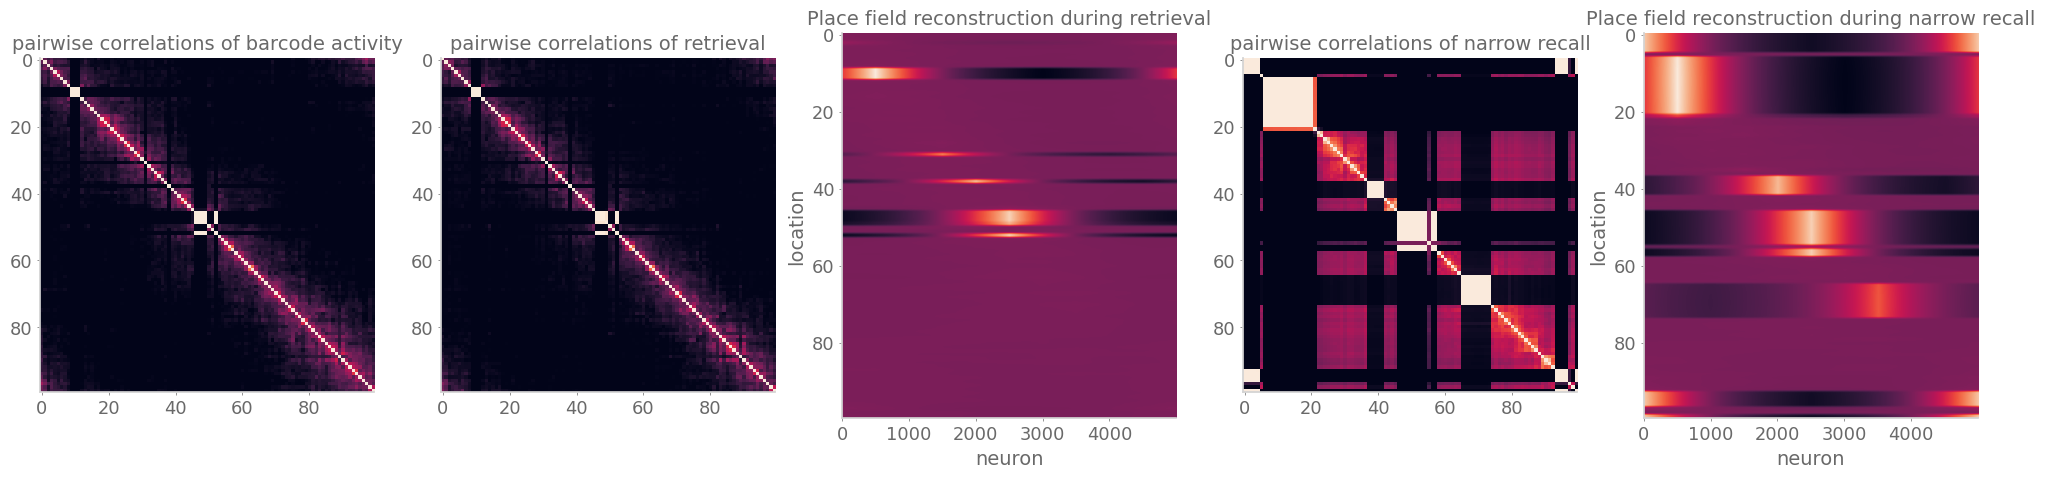

Now I just cached at location: 80


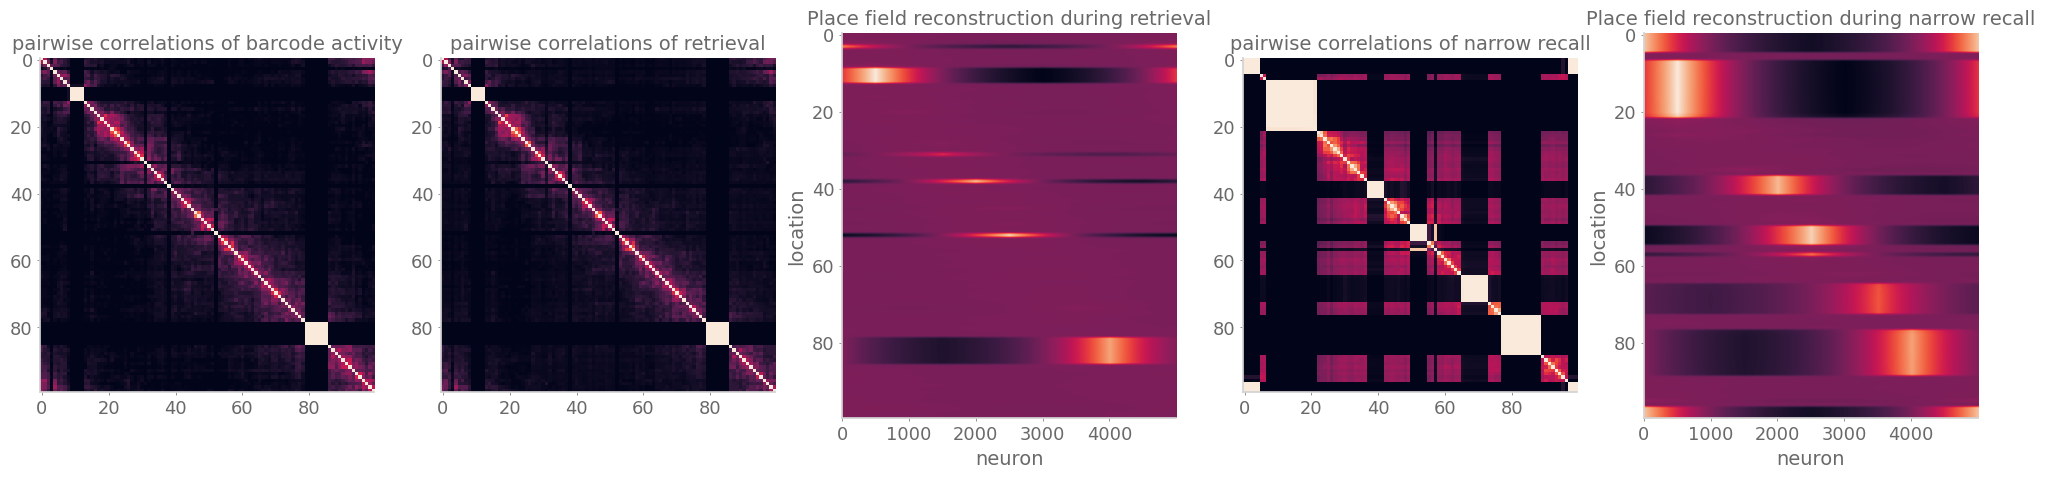

Now I just cached at location: 90


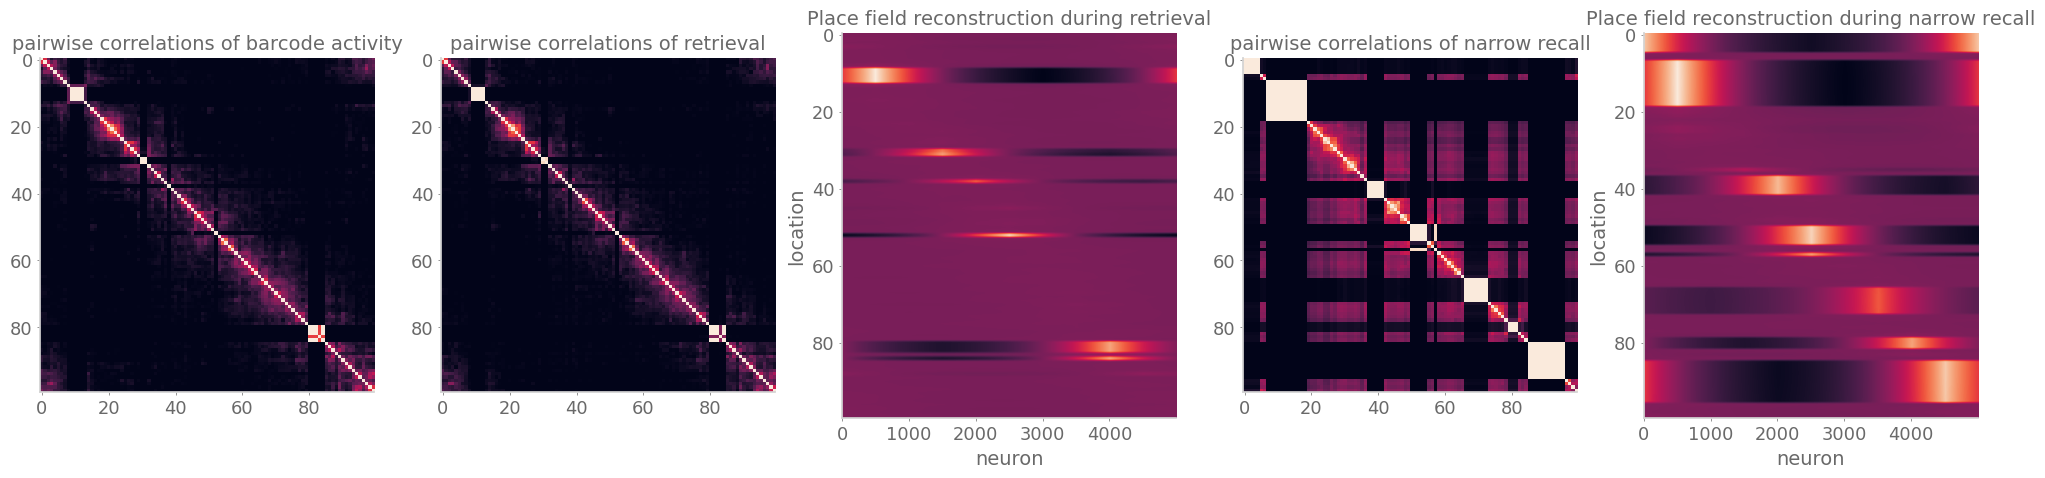

In [7]:
model.reset()
cache_acts = []
cache_acts_over_time = []
retrieval_acts_over_time = []
figsize=(4,3)

_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()
plt.figure(figsize=figsize)
plt.imshow(place_acts, vmin=0,  aspect='auto')
plt.xlabel("Input Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Input Activity")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(pairwise_correlations_centered(place_acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("Input Activity Spatial Correlation")
plt.xlabel("Input Neuron")
plt.ylabel("Input Neuron")
plt.show()

_, acts, _, _ = model.run_recurrent(place_inputs)
plt.figure(figsize=figsize)
plt.imshow(acts, vmin=0, vmax=1, aspect='auto')
plt.xlabel("RNN Neuron")
plt.ylabel("Location")
plt.colorbar()
plt.title("Cache Activity (recurrent mode)")
plt.show()

plt.figure(figsize=figsize)
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.xlabel("RNN Neuron")
plt.ylabel("RNN Neuron")
plt.colorbar()
plt.title("Cache Activity Spatial Correlation (recurrent mode)")
plt.show()

print(f'Sparsity: {np.mean(acts>0)}')

acts_normalized = normalize(acts, ax=0)
inputs_normalized = normalize(place_acts, ax=0)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())
    
    _, acts, _, _ = model.run_recurrent(place_inputs)
    ax[0].set_title("pairwise correlations of barcode activity")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)

    _, acts, reconstruct, acts_over_time = model.run_recall(0, place_inputs)
    ax[1].set_title("pairwise correlations of retrieval")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    ax[2].set_xlabel("neuron")
    ax[2].set_ylabel("location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction during retrieval")
    retrieval_acts_over_time.append(acts_over_time.copy())
    
    _, acts, reconstruct, _ = model.run_narrow_recall(place_inputs)
    ax[3].set_title("pairwise correlations of narrow recall")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    ax[4].set_xlabel("neuron")
    ax[4].set_ylabel("location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction during narrow recall")
    plt.show()
    

In [8]:
preacts, acts, rr, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)

# Fig 3ab, Fig 4: cache v. visit correlation

In [68]:
start_t = steps-25

In [69]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}

sim_func = poiss_corr
for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        # Not mean
        #cache_act_i = cache_acts[i][cache_states[i]]
        #cache_act_j = cache_acts[j][cache_states[j]]
        
        # Mean over time
        cache_act_i = cache_acts_over_time[i][start_t:steps, cache_states[i], :].mean(axis=0)
        cache_act_j = cache_acts_over_time[j][start_t:steps, cache_states[j], :].mean(axis=0)
        
        # Get correlations
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(2):
            c_c_corr = sim_func(cache_act_i, cache_act_j)
            c_v_corr = sim_func(cache_act_i, place_act_j)
            v_v_corr = sim_func(place_act_i, place_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)

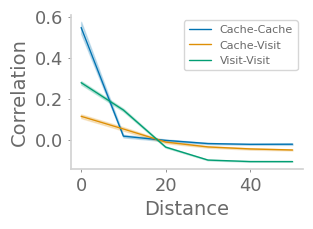

In [70]:
plt.figure(figsize=(3,2))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Cache', color='C0',
    data=pd.DataFrame(cache_cache_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Visit', color='C1',
    data=pd.DataFrame(cache_visit_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Visit-Visit', color='C2',
    data=pd.DataFrame(visit_visit_corr))
plt.legend()
plt.show()

# Fig 3c: Example barcodes and Fig 7: Projections in time

In [99]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Mean over time
    vec = cache_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
    
    # Not mean
    #vec = cache_acts[i][location]
    
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [100]:
long_avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][:, location, :].mean(axis=0) 
    long_avg_cache_acts.append(vec)
long_avg_cache_acts = np.array(long_avg_cache_acts)

In [101]:
occupied_check = avg_cache_acts
empty_check = place_acts[np.array(cache_states)]
seed_vec = empty_check - occupied_check
seed_vec = seed_vec.mean(axis=0)
seed_vec /= np.linalg.norm(seed_vec)

In [102]:
locations = []
barcodes = []
all_cache = []
all_proj = []
all_place = []
place_proj_in_time = []
barcode_proj_in_time = []
seed_proj_in_time = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Cache activations
    
    # Mean over time
    _cache_act = avg_cache_acts[i]
    cache_mean = np.mean(avg_cache_acts, axis=0)
    
    # Not mean
    #_cache_act = cache_acts[i][location]
    #cache_mean = np.mean(cache_acts, axis=0)
    
    _cache_act -= cache_mean
    _cache_act_over_time = cache_acts_over_time[i]
    
    # Place activations
    _place_act = place_acts[location].copy()
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    # Define barcode
    all_cache.append(_cache_act.copy())
    all_place.append(_place_act.copy())
    projection = np.dot(_cache_act, _place_act) * _place_act
    all_proj.append(projection.copy())
    locations.append(location)
    barcode = _cache_act - projection
    _cache_act /= np.linalg.norm(_cache_act)
    barcodes.append(barcode)
    
    # Over time
    _place_proj_in_time = []
    _barcode_proj_in_time = []
    _seed_proj_in_time = []
    for t in range(_cache_act_over_time.shape[0]):
        _c = _cache_act_over_time[t][location] # (n_units,)
        _place_proj_in_time.append(np.dot(_c, _place_act))
        _barcode_proj_in_time.append(np.dot(_c, _cache_act))
        _seed_proj_in_time.append(np.dot(_c, seed_vec))
    place_proj_in_time.append(_place_proj_in_time)
    barcode_proj_in_time.append(_barcode_proj_in_time)
    seed_proj_in_time.append(_seed_proj_in_time)

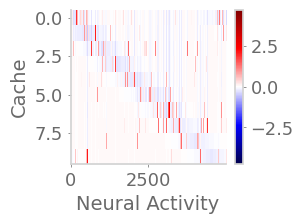

In [103]:
# Chettih et al Figure 3
x = np.array(barcodes)
plt.figure(figsize=(2.5,2))
plt.imshow(x, cmap='seismic', interpolation='nearest', aspect='auto')
plt.clim(-x.max(), x.max())
plt.colorbar()
plt.ylabel('Cache')
plt.xlabel('Neural Activity')
plt.show()

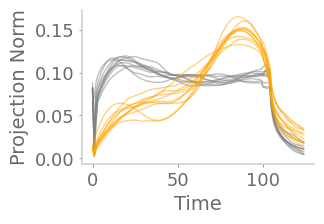

In [104]:
# Chettih et al Figure 7
plt.figure(figsize=(3,2))
for pp in place_proj_in_time:
    plt.plot(pp/np.linalg.norm(pp), alpha=0.5, color='gray')
for bp in barcode_proj_in_time:
    plt.plot(bp/np.linalg.norm(bp), alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.show()

# Testing for seed projections

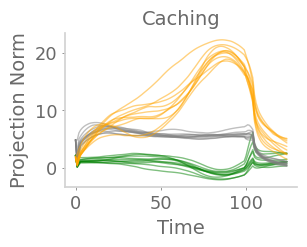

In [105]:
# Chettih et al Figure 7
plt.figure(figsize=(3,2))
for sp in seed_proj_in_time:
    plt.plot(sp,#/np.linalg.norm(sp),
        alpha=0.5, color='green')
for pp in place_proj_in_time:
    plt.plot(pp,#/np.linalg.norm(pp),
        alpha=0.5, color='gray')
for bp in barcode_proj_in_time:
    plt.plot(bp,#/np.linalg.norm(bp),
        alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.title('Caching')
plt.show()

In [106]:
place_proj_in_time = []
barcode_proj_in_time = []
seed_proj_in_time = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Mean over time
    _cache_act = avg_cache_acts[i]
    cache_mean = np.mean(avg_cache_acts, axis=0)
    
    _cache_act -= cache_mean
    _ret_act_over_time = retrieval_acts_over_time[-1]
    
    # Place activations
    _place_act = place_acts[location].copy()
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    # Over time
    _place_proj_in_time = []
    _barcode_proj_in_time = []
    _seed_proj_in_time = []
    for t in range(_ret_act_over_time.shape[0]):
        _c = _ret_act_over_time[t,location] # (n_units,)
        _place_proj_in_time.append(np.dot(_c, _place_act))
        _barcode_proj_in_time.append(np.dot(_c, _cache_act))
        _seed_proj_in_time.append(np.dot(_c, seed_vec))
    place_proj_in_time.append(_place_proj_in_time)
    barcode_proj_in_time.append(_barcode_proj_in_time)
    seed_proj_in_time.append(_seed_proj_in_time)

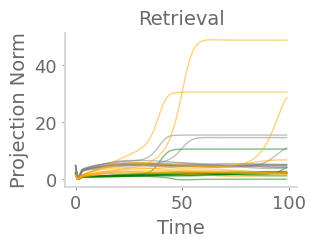

In [107]:
# Chettih et al Figure 7
plt.figure(figsize=(3,2))
for sp in seed_proj_in_time:
    plt.plot(sp,#/np.linalg.norm(sp),
        alpha=0.5, color='green')
for pp in place_proj_in_time:
    plt.plot(pp,#/np.linalg.norm(pp),
        alpha=0.5, color='gray')
for bp in barcode_proj_in_time:
    plt.plot(bp,#/np.linalg.norm(bp),
        alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.title('Retrieval')
plt.show()

# Fig 2: Barcode neuron participation

In [111]:
activities = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = avg_cache_acts[i].copy()
    activities.append((vec-place_mean)/place_std)

In [109]:
x.shape

(10, 5000)

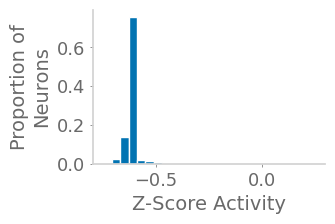

In [152]:
x = np.array(activities)
n_caches, n_neurons = x.shape
plt.figure(figsize=(3,2))
plt.hist(
    x.flatten(), bins=30,
    weights=[1/x.size]*x.size)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.xlim(-0.8,0.3)
plt.show()

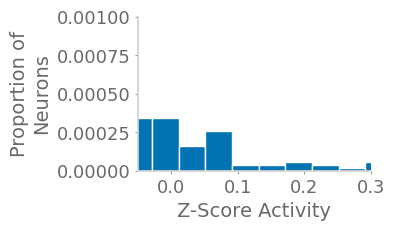

In [151]:
x = np.array(activities)
n_caches, n_neurons = x.shape
plt.figure(figsize=(3,2))
plt.hist(
    x.flatten(), bins=30,
    weights=[1/x.size]*x.size)
plt.ylabel('Proportion of\nNeurons')
plt.xlabel('Z-Score Activity')
plt.xlim(-0.05,0.3)
plt.ylim(0,0.001)
plt.show()

In [153]:
vals = []
for i in range(x.shape[1]):
    _x = x[:,i]
    p = np.sum(_x<0)/_x.size
    vals.append(p)
val = np.mean(vals)
print(f'Neurons fire under their place mean in {val*100:.2f} % of Caches')

Neurons fire under their place mean in 99.92 % of Caches
